In [7]:
import pandas as pd
import numpy as np
import re

# 路径配置
train_csv = "hgcal_gcn_train.csv"
test_normal_csv = "hgcal_gcn_test_normal.csv"
test_anomaly_csv = "hgcal_gcn_test_anomaly.csv"

# 读取 CSV
df_train = pd.read_csv(train_csv)
df_test_normal = pd.read_csv(test_normal_csv)
df_test_anom = pd.read_csv(test_anomaly_csv)

# 提取 wafer 坐标
feature_cols = df_train.columns[1:]
coords = []
for col in feature_cols:
    m = re.match(r"u(-?\d+)_v(-?\d+)", col)
    coords.append((int(m.group(1)), int(m.group(2))))

# 将 CSV 行变为 21x21 图像
def df_to_tensor(df, coords):
    images = []
    for idx, row in df.iterrows():
        image = np.zeros((21, 21), dtype=np.float32)
        for (u, v), value in zip(coords, row[1:]):
            iu, iv = u + 10, v + 10  # 坐标映射
            if 0 <= iu < 21 and 0 <= iv < 21:
                image[iv, iu] = value
        images.append(image)
    images = np.stack(images)
    images = images[:, np.newaxis, :, :]  # 转为 (N, 1, 21, 21)
    return images

X_train = df_to_tensor(df_train, coords)
X_test_normal = df_to_tensor(df_test_normal, coords)
X_test_anom = df_to_tensor(df_test_anom, coords)

print("Train shape:", X_train.shape)
print("Test normal shape:", X_test_normal.shape)
print("Test anomaly shape:", X_test_anom.shape)


Train shape: (720, 1, 21, 21)
Test normal shape: (180, 1, 21, 21)
Test anomaly shape: (180, 1, 21, 21)


In [9]:
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 构建模型
class CNN_AE(nn.Module):
    def __init__(self):
        super(CNN_AE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 8x10x10
            nn.Conv2d(8, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 16x5x5
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(16, 8, kernel_size=2, stride=2),  # 8x10x10
            nn.ReLU(),
            nn.ConvTranspose2d(8, 1, kernel_size=2, stride=2),   # 1x20x20
            nn.ReLU(),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

model = CNN_AE().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# 数据加载
train_loader = DataLoader(TensorDataset(torch.tensor(X_train)), batch_size=64, shuffle=True)

# 训练
n_epochs = 50
losses = []

model.train()
for epoch in range(n_epochs):
    total_loss = 0
    for batch in train_loader:
        inputs = batch[0].to(device)
        outputs = model(inputs)
        inputs_cropped = inputs[:, :, :20, :20]
        loss = criterion(outputs, inputs_cropped)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}: Loss = {total_loss / len(train_loader):.6f}")


Epoch 1: Loss = 0.239068
Epoch 2: Loss = 0.221796
Epoch 3: Loss = 0.206437
Epoch 4: Loss = 0.188161
Epoch 5: Loss = 0.163863
Epoch 6: Loss = 0.137377
Epoch 7: Loss = 0.122763
Epoch 8: Loss = 0.115795
Epoch 9: Loss = 0.111943
Epoch 10: Loss = 0.109031
Epoch 11: Loss = 0.106425
Epoch 12: Loss = 0.104077
Epoch 13: Loss = 0.101129
Epoch 14: Loss = 0.097335
Epoch 15: Loss = 0.093773
Epoch 16: Loss = 0.091082
Epoch 17: Loss = 0.089106
Epoch 18: Loss = 0.087689
Epoch 19: Loss = 0.086564
Epoch 20: Loss = 0.085804
Epoch 21: Loss = 0.085006
Epoch 22: Loss = 0.084573
Epoch 23: Loss = 0.084159
Epoch 24: Loss = 0.084001
Epoch 25: Loss = 0.083665
Epoch 26: Loss = 0.083553
Epoch 27: Loss = 0.083405
Epoch 28: Loss = 0.083321
Epoch 29: Loss = 0.083157
Epoch 30: Loss = 0.083038
Epoch 31: Loss = 0.082781
Epoch 32: Loss = 0.082764
Epoch 33: Loss = 0.082422
Epoch 34: Loss = 0.082424
Epoch 35: Loss = 0.082311
Epoch 36: Loss = 0.082219
Epoch 37: Loss = 0.082137
Epoch 38: Loss = 0.081968
Epoch 39: Loss = 0.08

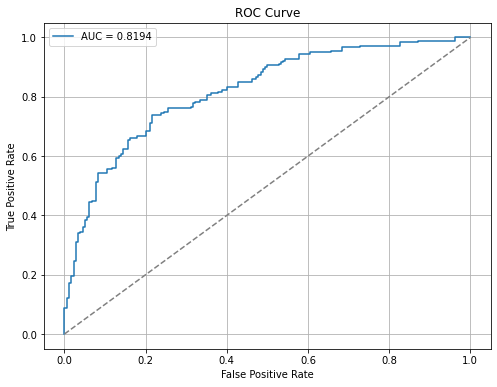

              precision    recall  f1-score   support

      Normal       0.61      0.95      0.74       180
     Anomaly       0.88      0.38      0.53       180

    accuracy                           0.67       360
   macro avg       0.75      0.67      0.64       360
weighted avg       0.75      0.67      0.64       360



In [10]:
from sklearn.metrics import roc_curve, auc, classification_report
import matplotlib.pyplot as plt

def compute_mse_errors(model, X_data):
    loader = DataLoader(torch.tensor(X_data), batch_size=1, shuffle=False)
    model.eval()
    errors = []
    with torch.no_grad():
        for x in loader:
            x = x.to(device)
            output = model(x)
            x_crop = x[:, :, :20, :20]
            mse = nn.functional.mse_loss(output, x_crop).item()
            errors.append(mse)
    return np.array(errors)

normal_errors = compute_mse_errors(model, X_test_normal)
anomaly_errors = compute_mse_errors(model, X_test_anom)

# 合并用于AUC
y_true = np.array([0] * len(normal_errors) + [1] * len(anomaly_errors))
y_scores = np.concatenate([normal_errors, anomaly_errors])

# ROC & AUC
fpr, tpr, _ = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.4f}')
plt.plot([0, 1], [0, 1], '--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

# 分类报告
threshold = np.percentile(normal_errors, 95)  # 95% quantile of normal as threshold
y_pred = (y_scores > threshold).astype(int)

report = classification_report(y_true, y_pred, target_names=["Normal", "Anomaly"])
print(report)
